In [1]:
import sys
sys.path.insert(0, '../top-k-mallows')
import permutil as pu
import mallows_kendall as mk
import numpy as np
from imp import reload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import collections




# Approximate uniform crossover under kendall distance



- Let `p1`, `p2` be two permutations. The `oracle[i,j]= p1[i]<p1[j]/2 + p1[i]<p1[j]/2`. 
- `sample` <- Use a probabilistic version of mergesort to sample from `oracle` `num_sampled` permutations. 
- `borda`Aggregate `sample` with Borda
- measure the relative error 

(we generate k samples from the mergesort-oracle and aggregate them, for k<n? k=log n?. Has to be better than $n^2$ of the trivial algorithm tipo bubble sort. Parece que da igual como sea n, k es constante, sobre los 20) we can show that: 
- the proc is $kn log n$ 
- the resulting permutation is in the middle (at the same distance from both parents, the same as the bubblesort)


# TODO
falta el analisis de convergencia

In [2]:
reload(pu)

def merge_sort_wrapped(data, oracle):
    """
    Numpy implementation of merge sort algorithm.
    https://gist.github.com/sadighian/7fed148eca457ec45f95afaf3da96f76
    returns the inverse of the oracle!! (->must invert the final result)
    """
    data_length = np.shape(data)[0]
    if data_length < 2:
        return data
    midpoint = data_length // 2    
    lefts = merge_sort_wrapped(data[:midpoint], oracle)
    rights = merge_sort_wrapped(data[midpoint:], oracle)
    results = np.empty(data_length, dtype=np.int32)
    l = r = 0
    idx = 0
    r_length = len(rights)
    l_length = len(lefts)
    while l < l_length and r < r_length:
#         if lefts[l] <= rights[r]:
        if oracle[lefts[l],rights[r]] >= np.random.random():
            results[idx] = lefts[l]
            l += 1
        else:
            results[idx] = rights[r]
            r += 1
        idx += 1
    while l < l_length:
        results[idx] = lefts[l]
        l += 1
        idx += 1
    
    while r < r_length:
        results[idx] = rights[r]
        r += 1
        idx += 1
    return results

def sort_oracle(perm, oracle, method='ms'):
    if method=='ms': 
        perm = merge_sort_wrapped(perm, oracle)
        return np.argsort(perm)

def sample_to_oracle(np_sample, margtype='relative'):
  #   pu.sample_to_marg_rel(np.array([perm1, perm2]))
  return pu.sample_to_marg(np_sample, margtype='relative')
    


# TEST for one
n=10
perm1, perm2 = np.random.permutation(n), np.random.permutation(n)
perm = perm1 # np.random.permutation(n)
oracle = pu.sample_to_marg(np.array([perm1, perm2]), margtype='relative')
perm_sorted = merge_sort_wrapped(perm, oracle)
# perm, perm_oracle, np.argsort(perm_sorted), sort_oracle(perm,oracle)

ms = sort_oracle(perm,oracle)
d1 = mk.distance(perm1,ms)
d2 = mk.distance(perm2,ms)
d12 = mk.distance(perm1,perm2)
d1,d2,d12, d1+d2

(11, 12, 21, 23)

In [3]:
oracle

array([[0. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. ],
       [0. , 0. , 0.5, 0.5, 1. , 0.5, 0.5, 1. , 0.5, 1. ],
       [0. , 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 0. , 1. , 0.5, 0.5, 1. , 0.5, 1. ],
       [0. , 0. , 0.5, 0. , 0. , 0.5, 0.5, 0.5, 0. , 0.5],
       [0. , 0.5, 0.5, 0.5, 0.5, 0. , 1. , 0.5, 0. , 1. ],
       [0. , 0.5, 0.5, 0.5, 0.5, 0. , 0. , 0.5, 0. , 1. ],
       [0. , 0. , 0.5, 0. , 0.5, 0.5, 0.5, 0. , 0. , 1. ],
       [0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ]])

## Test of the sorting method
when we sample just one permu from an oracle, how many pairs are incorrect??

the theoretical error is incorrect?? the empirical one converges to 0.1

Text(0.5, 1.0, '# discordant pairs of ONE permu\n sampled with MS')

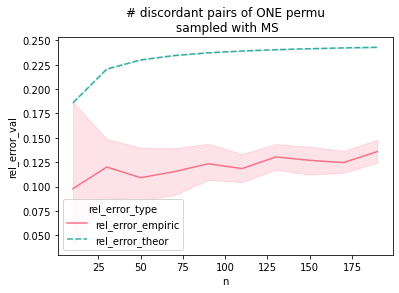

In [4]:
reload(mk)
res=[]
num_sample_range = range(1,2)
ns = range(10,200,20)
repes = 10
for n in ns:
    for _ in range(repes): 
        perm1, perm2 = np.random.permutation(n), np.random.permutation(n)
        d12 = mk.distance(perm1,perm2)
        oracle = sample_to_oracle(np.array([perm1, perm2]))
        for num_sampled in num_sample_range:
            perm =  np.random.permutation(n)
            sample = np.array([sort_oracle(perm, oracle) for i in range(num_sampled)])
            borda = mk.median(sample)
            d1 = mk.distance(perm1,borda)
            d2 = mk.distance(perm2,borda)
            res.append([n,num_sampled,d12,d1,d2])
            
df = pd.DataFrame(res,columns=['n','num_sampled','d12','d1','d2'])
df['dist_triang'] = df.d1+df.d2
df['rel_error_empiric'] = (df.dist_triang - df.d12)/(df.n*(df.n-1)/2)
df['rel_error_theor'] = (1 - np.log(df.n)/(df.n-1)) *.25

aux=(df.columns)
aux = aux.drop(['rel_error_empiric','rel_error_theor'])
df = df.melt(id_vars=aux, var_name="rel_error_type")
df.columns = [i if i!='value' else 'rel_error_val'for i in  df.columns]

color_variable='rel_error_type'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
sns.lineplot(data=df,x='n', y='rel_error_val', hue=color_variable, style='rel_error_type', palette=palette)
plt.title('# discordant pairs of ONE permu\n sampled with MS')
# # plt.savefig('img/mergesort.jpg')
# df.head()

## Experiment 
In this case  there exists a mode. the oracle is one and only one permu (the mode) but
how does `num_sampled` affect the quality for different values on $n$. If it has to be larger than $n$ then all thsi maekes no sense because we could use the bubble sort method whixh also allows to choose the distance ( and the same as thos one is not uniform) 

It is something constant, like 10?? (experimental result, see "when do noisy rankings reveal the truth") 

Is is log n, at most??

In [5]:
reload(mk)
res=[]
num_aggregated_range = [1,10,100,1000] #,5,10,50,100,300
total_repes = 30
noises = np.linspace(0,.5,20)
for n in [10]:
    for _ in range(total_repes): 
      for noise in noises:
          perm1, perm2 = np.random.permutation(n), np.random.permutation(n)
          #oracle = sample_to_oracle(np.array([perm1, perm2]))
          oracle = sample_to_oracle(np.array([perm1]))
          oracle[oracle==0] = noise
          oracle[oracle==1] = 1 - noise
          for num_aggregated in num_aggregated_range:
              perm =  np.random.permutation(n)
              sample = np.array([sort_oracle(perm, oracle) for i in range(num_aggregated)])
              borda = mk.median(sample)
              d1 = mk.distance(perm1,borda)
#               d2 = mk.distance(perm2,borda)
              res.append([n,num_aggregated,d1, noise])
df = pd.DataFrame(res,columns=['n','num_aggregated','d1','noise'])
df['rel_error_empiric'] = (df.d1)/(df.n*(df.n-1)/2)
color_variable='num_aggregated'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
plt.figure(figsize=(15,4))
sns.lineplot(data=df,x='noise', y='rel_error_empiric', hue=color_variable, palette=palette, style='n')
# plt.yscale('log')
plt.grid() 
a = plt.title('Distance from ground-true mode \n with Borda aggregation')
# plt.savefig('img/mergesort.jpg')
# df.head()

# como agregar las permus a lo largo de las iteraciones

Sea $k$ el indice de las iteraciones. vamos a asumir que $\rho$ ddecrece con $k$. Esto se puede hacer (1) fijando manualmente como decrece $\rho$ (para las primeras pruebas mejor ponerlo asi) o (2) como en el paper de UMM, desde los datos. Para tener una idea intuitiva, la evolución de la matriz M sería así

In [ ]:
rho = 0.01
n = 5
f_eval = np.array([np.random.random() for i in range(15)]) # valores de funcion de evaluacion (en realidad en el paper el max es 1 y el min es 0)
sample = np.array([np.random.permutation(range(n)) for i in range(15)])


ws = rho ** f_eval #pesos
perms_matrix = [pu.sample_to_marg(np.array([perm]), margtype='relative') for perm in sample]
([perm_mat*w for perm_mat, w in zip(perms_matrix, ws)])

# la suma de todas estas es la M

In [ ]:
f_eval